## CASE STUDY TWO: News Feed Clustering and Sentimental Analysis

### Extract weather data with the stream data API

This section is dedicated to a case study on testing the framework on unstructured dataset by extracting news topic on climate change from various online media outlet via News API website with millions of news articles and blogs. An API key is generated to be able to have access to the data endpoint with data format in JSON. Natural Language Processing and clustering techniques is applied to the news topics to determine the sentimental insight on the topic and how common the topic subject occurs in the News.

In [37]:
import requests
import json

url = "https://newsapi.org/v2/everything?q=climate&apiKey=408f9fb0be5d4aa4b480c794a85db203"
response_1 = requests.get(url)

if response_1.status_code == 200:
    data_1 = response_1.json()
    #print(data_1) 
    # Do something with the data
else:
    print("Error fetching data from API")

### Kafka Data Ingestion

In [2]:
from kafka import KafkaProducer

# Set up Kafka producer
producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'],
                             value_serializer=lambda x: json.dumps(x).encode('utf-8'))

# Send data to Kafka topic
producer.send('newsfeeddata1', data_1)
producer.flush()

### Spark Session Set up

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("KafkaNewsStream") \
    .getOrCreate()

#Set Spark logging level to ERROR to avoid various other logs on console.
spark.sparkContext.setLogLevel("ERROR")
spark.sql("set spark.sql.streaming.schemaInference=true");


In [41]:
spark

### Define Stream Data Schema and Data Type

In [43]:
# define the schema for the articles field
article_schema = StructType([
    StructField("title", StringType()),
    StructField("author", StringType()),
    StructField("source", StructType([
        StructField("id", StringType()),
        StructField("name", StringType())
    ])),
    StructField("publishedAt", TimestampType()),
    StructField("url", StringType())
])

# define the main schema for the entire JSON message
json_schema = StructType([
    StructField("status", StringType()),
    StructField("totalResults", StringType()),
    StructField("articles", ArrayType(article_schema))
])


### Structured Streaming Module

Setting the "failOnDataLoss" option to "false" means that Spark will not fail the query if it detects data loss, but instead, it will log a warning message. This is useful when you want to tolerate some data loss in your streaming application, and you don't want it to fail every time it detects data loss

In [44]:
# read streaming data from Kafka
df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", "newsfeeddata1") \
    .option("startingOffsets", "earliest") \
    .option("failOnDataLoss", "false") \
    .load()


#### Parse to derive data values from Article nested json object

In [45]:
# convert the binary Kafka value to string and parse the JSON
parsed_df = df.selectExpr("CAST(value AS STRING)") \
    .select(from_json("value", json_schema, options={"allowUnquotedControlChars": True}).alias("parsed_value")) \
    .selectExpr("parsed_value.status",
                "parsed_value.totalResults",
                "inline_outer(parsed_value.articles)").select("title", "author", "source.*", "publishedAt", "url")



In [46]:
# print schema for article object 
parsed_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- publishedAt: timestamp (nullable = true)
 |-- url: string (nullable = true)



In [47]:
import pandas as pd

# Define a function to write each micro-batch to a Pandas DataFrame
def write_to_pandas(df, epoch_id):
    # Convert the Spark DataFrame to a Pandas DataFrame
    pandas_df = df.toPandas()
    # Print the Pandas DataFrame
    display(pandas_df)

In [48]:
# Define the streaming query
streaming_data = parsed_df.writeStream \
    .foreachBatch(write_to_pandas) \
    .outputMode("append") \
    .start()

2023-04-30 19:59:38.640 INFO    py4j.clientserver: Python Server ready to receive messages
2023-04-30 19:59:38.643 INFO    py4j.clientserver: Received command c on object id p2


,title,author,id,name,publishedAt,url
0,"Washington, DC’s Cherry Blooms Draw Crowds—and...",Emma Ricketts,None,None,2023-04-01 13:00:00,https://www.wired.com/story/washington-cherry-...
1,Can Burning Man Pull Out of Its Climate Death ...,Alden Wicker,None,None,2023-04-04 13:00:00,https://www.wired.com/story/burning-man-climat...
2,Mitsubishi wants to be the world’s carbon broker,Justine Calma,None,None,2023-04-28 19:45:59,https://www.theverge.com/2023/4/28/23702343/mi...
3,"To capture CO2 in the US, climate tech startup...",Justine Calma,None,None,2023-04-21 19:54:20,https://www.theverge.com/2023/4/21/23690040/cl...
4,The Link Between Tornadoes and Climate Change ...,Angely Mercado,None,None,2023-03-31 19:34:00,https://gizmodo.com/tornadoes-and-climate-chan...
...,...,...,...,...,...,...
391,The EPA's watchdog is warning about oversight ...,Eric McDaniel,None,None,2023-04-01 10:01:09,https://www.npr.org/2023/04/01/1167334678/epa-...
392,"Meet the One Planet Advisory Council, a group ...",Business Insider,None,None,2023-04-03 19:02:05,https://www.businessinsider.com/meet-one-plane...
393,The steps that could help address biodiversity...,Catherine Boudreau,None,None,2023-04-24 20:05:52,https://www.businessinsider.com/biodiversity-l...
394,3 experts discuss the impact of climate change...,Elizabeth Wood,None,None,2023-04-25 18:01:46,https://www.businessinsider.com/experts-share-...


#### Delta Table

In [49]:
stream_query = parsed_df.writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("word_my_query") \
    .start()

stream = spark.sql("SELECT * FROM word_my_query")

In [50]:
from delta.tables import *
# Write the stream to Delta Lake
stream1 =stream.write.format("delta").mode("append").save("/tmp/df_title_table")

# Read the streaming from Delta Lake and display as pandas table
stream2 = spark.read.format("delta").load("/tmp/df_title_table")

# Load Delta table as DataFrame
display(DeltaTable.forPath(spark, "/tmp/df_title_table").toDF().toPandas())

,title,author,id,name,publishedAt,url
0,"Washington, DC’s Cherry Blooms Draw Crowds—and...",Emma Ricketts,None,None,2023-04-01 13:00:00,https://www.wired.com/story/washington-cherry-...
1,Can Burning Man Pull Out of Its Climate Death ...,Alden Wicker,None,None,2023-04-04 13:00:00,https://www.wired.com/story/burning-man-climat...
2,Mitsubishi wants to be the world’s carbon broker,Justine Calma,None,None,2023-04-28 19:45:59,https://www.theverge.com/2023/4/28/23702343/mi...
3,"To capture CO2 in the US, climate tech startup...",Justine Calma,None,None,2023-04-21 19:54:20,https://www.theverge.com/2023/4/21/23690040/cl...
4,The Link Between Tornadoes and Climate Change ...,Angely Mercado,None,None,2023-03-31 19:34:00,https://gizmodo.com/tornadoes-and-climate-chan...
...,...,...,...,...,...,...
391,Cop28 President: World Needs Business Mindset ...,msmash,None,None,2023-04-07 21:40:00,https://news.slashdot.org/story/23/04/07/19212...
392,It’s Way Too Easy to Get Google’s Bard Chatbot...,Vittoria Elliott,None,None,2023-04-05 05:47:22,https://www.wired.com/story/its-way-too-easy-t...
393,Noah Raford Can Help You Prepare for a Not-So-...,WIRED Staff,None,None,2023-04-26 12:00:00,https://www.wired.com/story/have-a-nice-future...
394,The UK will spend £100 million to develop its ...,Jon Fingas,None,None,2023-04-24 15:35:07,https://www.engadget.com/the-uk-is-creating-a-...


##### Machine Learning

In [149]:
# Machine learning libararies
from pyspark.ml.feature import *
from pyspark.ml.clustering import *
from pyspark.sql.functions import *
from pyspark.ml import *
from pyspark.ml.evaluation import *
from textblob import TextBlob
import matplotlib.pyplot as plt
import streamlit as st
import seaborn as sns

##### NLP Transformation: tokenizer, stop words, vectorizer

In [52]:
# apply transformations to streaming DataFrame

# Tokenize the title column
tokenizer = Tokenizer(inputCol="title", outputCol="words")
words_df = tokenizer.transform(stream2)

# Remove stop words from the tokenized words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_df = remover.transform(words_df)

# Vectorize the filtered words
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
vectorized_df = vectorizer.fit(filtered_df).transform(filtered_df)

#pipeline = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer])


##### Frequency

In [58]:
# create the CountVectorizer model on the streaming data
cv = CountVectorizer(inputCol="filtered_words", outputCol="features", vocabSize=1000, minDF=2.0)
cv_model = cv.fit(filtered_df)

# define a UDF to convert the features column to a string column
features_to_str = udf(lambda x: ' '.join([str(i) for i in x.indices]), StringType())

# apply the UDF to the features column
result = cv_model.transform(filtered_df)
result = result.withColumn("feature_str", features_to_str(result["features"]))

# split the feature_str column and count the words
word_counts = result \
    .select(explode(split("feature_str", " ")).alias("word")) \
    .groupBy("word") \
    .count() \
    .orderBy("count", ascending=False)

In [59]:
display(word_counts.toPandas())

,word,count
0,0,308
1,1,186
2,2,152
3,3,48
4,4,46
...,...,...
613,608,2
614,569,2
615,611,2
616,542,2


In [60]:
# get the vocabulary from the CountVectorizerModel
vocab = cv_model.vocabulary

# create a dataframe with word and count columns
word_count = spark.createDataFrame([(word, count) for word, count in zip(vocab, word_counts.select("count").rdd.flatMap(lambda x: x).collect())], ["word", "count"])

# order the dataframe by count in descending order
word_count = word_count.orderBy("count", ascending=False)

# replace None values with 0
word_count = word_count.na.fill(0)


In [61]:
# Replace '-' and '...' with an empty string in the 'word' column
word_freq = word_count.withColumn('word', regexp_replace('word', '[-|...]',''))

In [62]:
# display the dataframe
word_freq_dis = display(word_freq.limit(20).na.drop().toPandas())

,word,count
0,climate,308
1,,186
2,reuters,152
3,,48
4,change,46
5,reuterscom,28
6,vote,24
7,activists,24
8,world,22
9,resolution,22


##### K-Means Clustering

In [114]:
# Train the k-means model with k = 5
kmeans = KMeans(k=5, seed=1)
model = kmeans.fit(vectorized_df.select("features"))

# Add the predicted cluster column to the DataFrame
kmeans_predictions = model.transform(vectorized_df)

# Convert the DataFrame to pandas for visualization
kmeans_pandas_df = kmeans_predictions.select("title", "prediction").toPandas()



In [134]:
display(kmeans_pandas_df)

,title,prediction
0,"Washington, DC’s Cherry Blooms Draw Crowds—and...",1
1,Can Burning Man Pull Out of Its Climate Death ...,1
2,Mitsubishi wants to be the world’s carbon broker,1
3,"To capture CO2 in the US, climate tech startup...",1
4,The Link Between Tornadoes and Climate Change ...,1
...,...,...
391,Cop28 President: World Needs Business Mindset ...,1
392,It’s Way Too Easy to Get Google’s Bard Chatbot...,1
393,Noah Raford Can Help You Prepare for a Not-So-...,1
394,The UK will spend £100 million to develop its ...,1


have a larger number of data points that share common words, resulting in more scattered bubbles in those clusters.

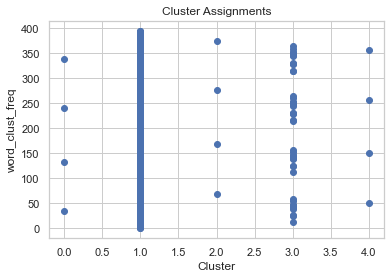

In [115]:
# Visualize the clusters with a scatter plot
plt.scatter(kmeans_pandas_df['prediction'], kmeans_pandas_df.index)
plt.xlabel('Cluster')
plt.ylabel('word_clust_freq')
plt.title('Cluster Assignments')
plt.show()

#### Word Cloud

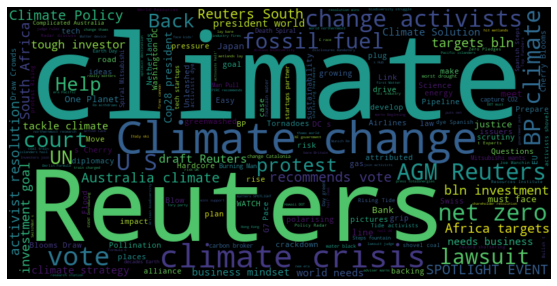

In [121]:
# Filter the kmeans_pandas_df to get the rows in the most clustered cluster
most_clustered_cluster = kmeans_pandas_df[kmeans_pandas_df['prediction'] == 1]

# Combine the titles into a single string
text = ' '.join(most_clustered_cluster['title'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.show()


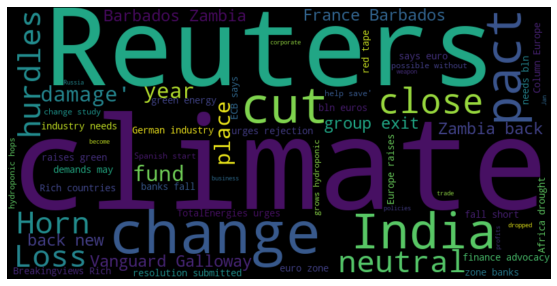

In [128]:
# Filter the kmeans_pandas_df to get the rows in the most clustered cluster
most_clustered_cluster = kmeans_pandas_df[kmeans_pandas_df['prediction'] == 3]

# Combine the titles into a single string
text = ' '.join(most_clustered_cluster['title'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.show()


###### Increase value of k to 7

In [135]:
# Train the k-means model with k = 5
kmeans_7 = KMeans(k=7, seed=1)
model_7 = kmeans_7.fit(vectorized_df.select("features"))

# Add the predicted cluster column to the DataFrame
kmeans_predictions_7 = model_7.transform(vectorized_df)

# Convert the DataFrame to pandas for visualization
kmeans_pandas_df_7 = kmeans_predictions_7.select("title", "prediction").toPandas()


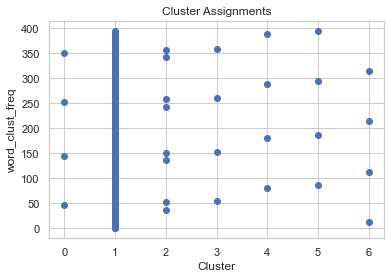

In [136]:
# Visualize the clusters with a scatter plot
plt.scatter(kmeans_pandas_df_7['prediction'], kmeans_pandas_df_7.index)
plt.xlabel('Cluster')
plt.ylabel('word_clust_freq')
plt.title('Cluster Assignments')
plt.show()

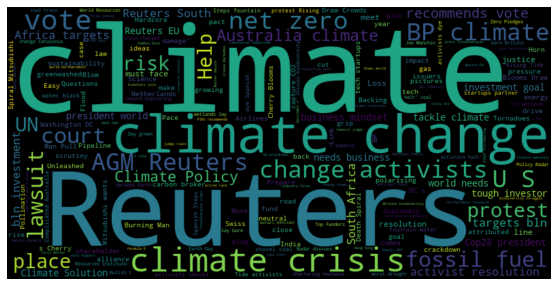

In [140]:
# Filter the kmeans_pandas_df to get the rows in the most clustered cluster
most_clustered_cluster = kmeans_pandas_df_7[kmeans_pandas_df_7['prediction'] == 1]

# Combine the titles into a single string
text = ' '.join(most_clustered_cluster['title'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.show()

##### Sentimental analysis

In [92]:
def get_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

# Define a UDF for the get_sentiment() function
get_sentiment_udf = udf(get_sentiment, FloatType())


# Add a new column with the sentiment polarity
vectorized_df_sen = vectorized_df.withColumn('sentiment_polar', get_sentiment_udf('title'))

# Add a new column with the sentiment label
vectorized_df_sen = vectorized_df_sen.withColumn('sentiment_label', get_sentiment_label_udf('sentiment_polar'))

In [71]:
# Define a function to get the sentiment polarity of a word
def get_word_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Define a UDF for the get_word_sentiment() function
get_word_sentiment_udf = udf(get_word_sentiment, FloatType())


In [72]:
# Create a new dataframe with the sentiment polarity of each word
sentiment_df = word_count.selectExpr("explode(split(word, ' ')) as word_p") \
                    .withColumn('sentiment_polarity', get_word_sentiment_udf('word_p')) \
                    .filter('sentiment_polarity != 0')


In [73]:
# Define a function to get the sentiment label
def get_sentiment_label(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Define a UDF for the get_sentiment_label() function
get_sentiment_label_udf = udf(get_sentiment_label, StringType())

# Add a new column with the sentiment label
sentiment_df = sentiment_df.withColumn('sentiment_label', get_sentiment_label_udf('sentiment_polarity'))


In [98]:
kmeans = KMeans(k=4, seed=1)
model_k = kmeans.fit(vectorized_df_sen.select("features"))

# Add the predicted cluster column to the DataFrame
#kmeans_predictions_sen = model_k.transform(vectorized_df_sen)

kmeans_predictions_sen = model_k.transform(vectorized_df_sen.select("title","features", "sentiment_polar", "sentiment_label"))

# Convert the DataFrame to pandas for visualization
kmeans_pandas_df_sen = kmeans_predictions_sen.select("title", "prediction","sentiment_polar","sentiment_label").toPandas()



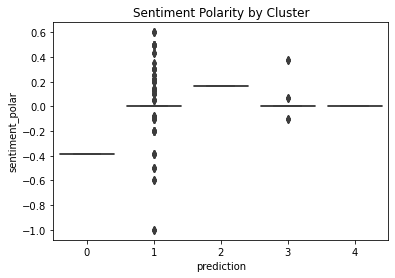

In [95]:
sns.boxplot(x='prediction', y='sentiment_polar', data=kmeans_pandas_df_sen)
plt.title('Sentiment Polarity by Cluster')
plt.show()

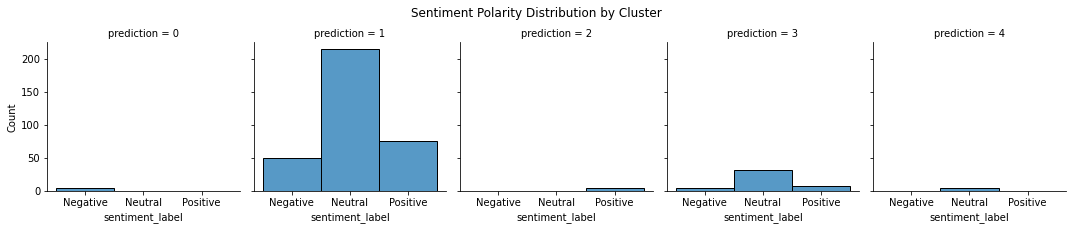

In [99]:
g = sns.FacetGrid(kmeans_pandas_df_sen, col='prediction')
g.map(sns.histplot, 'sentiment_label')
plt.suptitle('Sentiment Polarity Distribution by Cluster', y=1.05)
plt.show()

##### Clustering Evaluation

Silhouette Score


In [153]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(kmeans_predictions)
print("Silhouette Score = " + str(silhouette))

Silhouette Score = -0.013331837391900355


In [154]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(kmeans_predictions_7)
print("Silhouette Score = " + str(silhouette))

Silhouette Score = -0.06381339712006173


Within-Cluster Sum of Squares (WCSS)

In [156]:
# Calculate Within-Cluster Sum of Squares (WCSS)
evaluator = ClusteringEvaluator()
wcss = evaluator.evaluate(kmeans_predictions)
print("Within-Cluster Sum of Squares = " + str(wcss))

Within-Cluster Sum of Squares = -0.013331837391900355


Elbow method

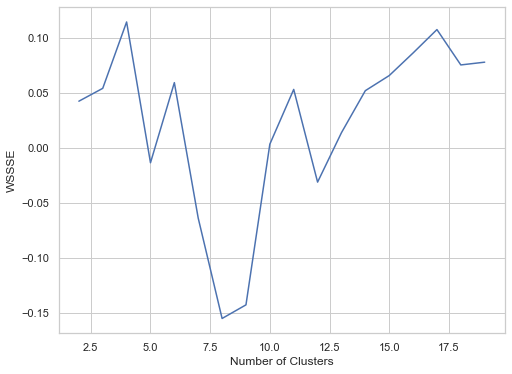

In [159]:
# elbow method to find optimal number of clusters
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(vectorized_df)
    predictions = model.transform(vectorized_df)
    evaluator = ClusteringEvaluator()
    cost[k] = evaluator.evaluate(predictions)

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('WSSSE')
plt.show()

###### Elbow Method Optimised Clusters k= 4

In [160]:
# Train the k-means model with k = 5
kmeans_4 = KMeans(k=4, seed=1)
model_4 = kmeans.fit(vectorized_df.select("features"))

# Add the predicted cluster column to the DataFrame
kmeans_predictions_4 = model_4.transform(vectorized_df)

# Convert the DataFrame to pandas for visualization
kmeans_pandas_df_4 = kmeans_predictions_4.select("title", "prediction").toPandas()



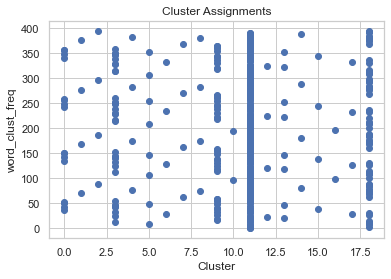

In [161]:
# Visualize the clusters with a scatter plot
plt.scatter(kmeans_pandas_df_4['prediction'], kmeans_pandas_df_4.index)
plt.xlabel('Cluster')
plt.ylabel('word_clust_freq')
plt.title('Cluster Assignments')
plt.show()

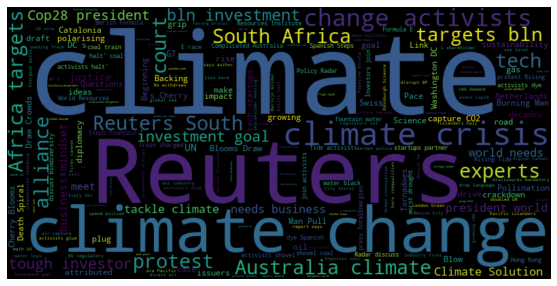

In [167]:
# Filter the kmeans_pandas_df to get the rows in the most clustered cluster
most_clustered_cluster = kmeans_pandas_df[kmeans_pandas_df_4['prediction'] == 11]

# Combine the titles into a single string
text = ' '.join(most_clustered_cluster['title'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.show()

In [8]:
# Calculate Within-Cluster Sum of Squares (WCSS)
evaluator = ClusteringEvaluator()
wcss = evaluator.evaluate(kmeans_predictions_4)
print("Within-Cluster Sum of Squares = " + str(wcss))

In [35]:
# restart query table if necessary
for q in spark.streams.active:
    if q.name == "word_my_query":
        q.stop()
